<a href="https://colab.research.google.com/github/FarizKesten/IntrusionDetection/blob/main/RealTimeIntrusionDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tasks:
1. Training: Build a detection model that can detect footsteps and fence climbing given the provided data.
2. Inference: Implement a prototype that can read DAS data, run the detection model and output when
and where in the provided data footsteps resp. fence climbing occurs.
3. Visualize the output of the prototype in some way and evaluate the real-time capability of the prototype.
4. Given a few samples from a different installation, evaluate and (if necessary) adjust such that the
detection still works.

### importing all necessaries libraries

In [2]:
# Adding neccesary libraries
import os
import math
import time
import glob
import random
import numpy as np
import importlib.util
from scipy import signal
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.optim import lr_scheduler
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torchvision.transforms as T
import albumentations as A
import torchvision.transforms.functional as F

import random

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


In [3]:
'''
PATH-ACCESS: PLEASE CHANGE THE PATH TO YOUR CURRENT PATH

For convenience I saved all the data from the E-Mail to my Drive,
however I keep it private so that no one from outside could retrieve it. I can give acces to the Drive if neccessary
Otherwise, pleas replace the location of the data to run the script
'''

base_path = '/content/drive/MyDrive/ds_challenge'
path_task1 = os.path.join(base_path, 'Task1')
path_task2 = os.path.join(base_path, 'Task2')
path_task4 = os.path.join(base_path, 'Task4')
path_model = os.path.join(base_path, 'model')


In [4]:
def read_image(path):

  """
  reading image from the disk, filter them and return them
  """

  data = np.load(path)
  data = np.cumsum(data, axis=0, dtype=np.int64).astype(np.float32)
  # Convert to radians
  data *= np.pi / 2**15

  # most likely want to highpass filter now to reduce low frequency noise
  sos = signal.butter(2, 5, "high", fs=1000, output="sos")
  data = signal.sosfiltfilt(sos, data, axis=0)
  return np.ascontiguousarray(data)

# Viewing sample images to get better understanding

Viewing the 3 classes as well as inference to understand the current dataset

float64


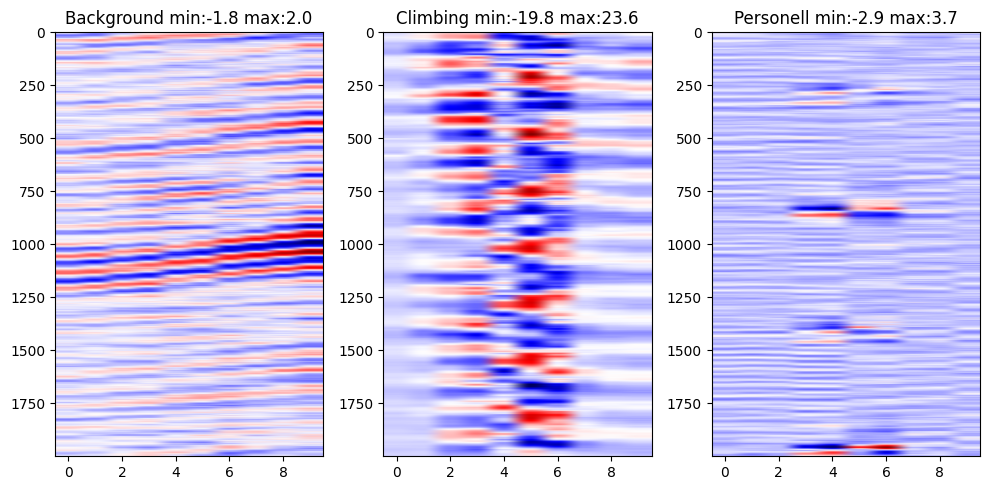

In [5]:
# find all training images

task = path_task1
#task = path_task4

# background
bgd_img = glob.glob(
    os.path.join(task, 'training', 'background', '**', '*.npy'),
    recursive=True
)

# climbing images
clm_img = glob.glob(
    os.path.join(task, 'training', 'climbing', '**', '*.npy'),
    recursive=True
)

# personnel
prs_img = glob.glob(
    os.path.join(task, 'training', 'personnel', '**', '*.npy'),
    recursive=True
)

# try to view 1 image of each class
idx = random.randint(0, min(len(bgd_img) - 1, len(clm_img) - 1, len(prs_img) - 1))
bgd = np.load(bgd_img[idx])
clm = np.load(clm_img[idx])
prs = np.load(prs_img[idx])

bgd = read_image(bgd_img[idx])
clm = read_image(clm_img[idx])
prs = read_image(prs_img[idx])

fig, axes = plt.subplots(1, 3, figsize=(10, 5))

cmap = 'seismic'
#axes[0].imshow(bgd, cmap=cmap, aspect="auto" )
axes[0].imshow(bgd, cmap=cmap, aspect="auto" )
print(bgd.dtype,)
axes[0].set_title(f"Background min:{np.min(bgd):.1f} max:{np.max(bgd):.1f}")
#axes[0].axis('off')

axes[1].imshow(clm, cmap=cmap, aspect="auto")
axes[1].set_title(f"Climbing min:{np.min(clm):.1f} max:{np.max(clm):.1f}")
#axes[1].axis('off')

axes[2].imshow(prs, cmap=cmap, aspect="auto")
axes[2].set_title(f"Personell min:{np.min(prs):.1f} max:{np.max(prs):.1f}")
#axes[2].axis('off')

plt.tight_layout()
plt.show()



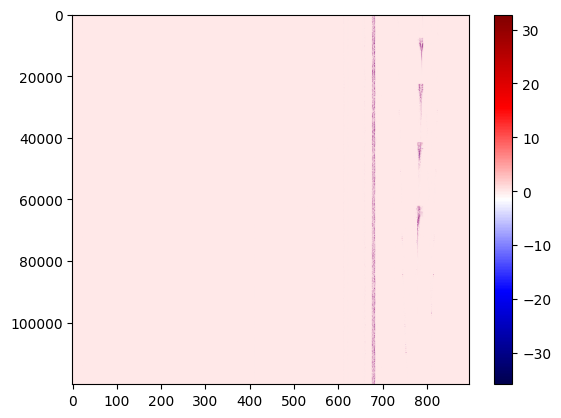

In [6]:
# view inference image

# inference
inf_img = glob.glob(
    os.path.join(path_task2, 'inference', '*.npy'),
    recursive=True
)

inference_image = read_image(inf_img[0])
plt.imshow(inference_image, cmap="seismic", aspect="auto")
plt.colorbar()
plt.show()


# Task 1 : Training

I see this as a segmentation task since we also need to localize the class in the image.

For rapid-prototyping of segmentation models I would use the segmentaiton-models-pytorch library

In [7]:
if importlib.util.find_spec('segmentation_models_pytorch') is None:
    !pip install -q segmentation-models-pytorch > /dev/null 2>&1

import segmentation_models_pytorch as smp


In [ ]:
# CONSTANTS
BATCH_SIZE = 4
CLASS_ID = { "background" : 0, "climbing" : 1, "personnel" : 2}

### Preparing Dataset Pipeline


In [ ]:


class SegmentationDataset(Dataset):
  """
  Setting up datasets for training, validation and testing
  """
  def __init__(self, image_path, class_id, transform=False):
    self.transform = transform
    self.class_id = class_id

    self.image_path = image_path

    # image augmentations
    if self.transform:
      frequency = 0.3
      self.aug_transform = A.Compose([
          A.HorizontalFlip(p=frequency),
          A.VerticalFlip(p=frequency),
          A.Rotate(limit=30, p=frequency),
      ], additional_targets={'mask': 'mask'})


  def __len__(self):
    return len(self.image_path)


  def __getitem__(self, index):
    '''
    get both images and create a mask filled with the class_id.
    Assumption: each image has a corresponding mask without
    background information
    '''
    image = read_image(self.image_path[index])
    height, width = image.shape

    # generate mask. Current approach: fill the whole pixel with the class-id
    mask  = np.full((height, width),
                    fill_value=self.class_id[index],
                    dtype=np.int32
                    )

    # If augmentation is enabled, apply Albumentations.
    if self.transform:
        image_aug = image[..., np.newaxis]  # shape becomes [H, W, 1]
        augmented = self.aug_transform(image=image_aug, mask=mask)
        image_aug = augmented["image"]
        mask = augmented["mask"]
    else:
        image_aug = image[..., np.newaxis]

    image_tensor = torch.from_numpy(image_aug).permute(2, 0, 1)
    mask_tensor = torch.from_numpy(mask)

    # Determine padding needed (to make height & width divisible by 32)
    #(needed for example by U-Net)
    pad_h = (32 - height % 32) if height % 32 != 0 else 0
    pad_w = (32 - width % 32) if width % 32 != 0 else 0

    # Apply padding (PyTorch uses (left, right, top, bottom) format)
    padder = nn.ConstantPad2d((0, pad_w, 0, pad_h), 0)
    image_tensor = padder(image_tensor)
    mask_tensor = padder(mask_tensor)

    return image_tensor.float(), mask_tensor.long()


def gather_class_paths(task_dir, split="training", class_name="background", class_id=0):
  '''
  gather all image paths for a given class
  '''
  search_pattern = os.path.join(task_dir, split, class_name, '**', '*.npy')
  image_paths = glob.glob(search_pattern, recursive=True)

  class_ids = [class_id] * len(image_paths)

  return image_paths, class_ids

################################################################################
# collect all training data
################################################################################
bg_path, bg_id = gather_class_paths(task_dir=path_task1, split="training",
                                    class_name="background",
                                    class_id=CLASS_ID["background"])
prs_path, prs_id = gather_class_paths(task_dir=path_task1, split="training",
                                      class_name="personnel",
                                      class_id=CLASS_ID["personnel"])
clm_path, clm_id = gather_class_paths(task_dir=path_task1, split="training",
                                      class_name="climbing",
                                      class_id=CLASS_ID["climbing"])

all_training_path = bg_path + prs_path + clm_path
all_training_id = bg_id + prs_id + clm_id

train_dataset = SegmentationDataset(
    image_path=all_training_path,
    class_id=all_training_id,
    transform=True
)
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)


################################################################################
# collect all validation & test data (20% goes to test dataset)
################################################################################
bg_path, bg_id = gather_class_paths(task_dir=path_task1, split="validation",
                                    class_name="background",
                                    class_id=CLASS_ID["background"])
prs_path, prs_id = gather_class_paths(task_dir=path_task1, split="validation",
                                      class_name="personnel",
                                      class_id=CLASS_ID["personnel"])
clm_path, clm_id = gather_class_paths(task_dir=path_task1, split="validation",
                                      class_name="climbing",
                                      class_id=CLASS_ID["climbing"])

all_paths = bg_path + prs_path + clm_path
all_ids = bg_id + prs_id + clm_id

val_paths, test_paths, val_ids, test_ids = train_test_split(
    all_paths, all_ids, test_size=0.2, random_state=42, stratify=all_ids
)


val_dataset = SegmentationDataset(
    image_path=val_paths,
    class_id=val_ids,
    transform=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

test_dataset = SegmentationDataset(
    image_path=test_paths,
    class_id=test_ids,
    transform=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)


print(f"Number of training dataset: {len(train_dataset)}")
print(f"Number of validation dataset: {len(val_dataset)}")
print(f"Number of test dataset: {len(test_dataset)}")


Number of training dataset: 2699
Number of validation dataset: 1415
Number of test dataset: 354


### Choosing the Model for classification

Potentially multiple models can be use to train and test for its performance

In [ ]:
##################################################################
# try out multiple model candidates
##################################################################

encoder_name = "resnet34"
encoder_weights = "imagenet"
in_channels=1
classes=3


models = {
  "PSPNet": {
        "model": smp.PSPNet(
            encoder_name=encoder_name,
            encoder_weights=encoder_weights,
            in_channels=in_channels,
            classes=classes
        ),
        "lr": 0.005
    },
    # Lightweight and supposed to be fast
     "LinkNet": {
        "model" : smp.Linknet(
            encoder_name=encoder_name,
            encoder_weights=encoder_weights,
            in_channels=in_channels,
            classes=classes
        ),
        "lr" : 0.005
    },
    # Lightweight and Fast
    "FPN": {
        "model" : smp.FPN(
          encoder_name=encoder_name,
          encoder_weights=encoder_weights,
          in_channels=in_channels,
          classes=classes
      ),
    "lr" : 0.005
    },

    # Klassiker
    "Unet": {
        "model" :smp.Unet(
            encoder_name=encoder_name,
            encoder_weights=encoder_weights,
            in_channels=in_channels,
            classes=classes
        ),
        "lr" : 0.001
    },

    "Unet++": {
        "model" :smp.Unet(
            encoder_name=encoder_name,
            encoder_weights=encoder_weights,
            in_channels=in_channels,
            classes=classes
        ),
        "lr" : 0.005
    },

  "DeepLabV3Plus": {
      "model" : smp.DeepLabV3Plus(
          encoder_name=encoder_name,
          encoder_weights=encoder_weights,
          in_channels=in_channels,
          classes=classes
        ),
      "lr" : 0.005
  },

}

# printing all models that are used
print("models under tests: \n")
for key, model in models.items():
  print(key)

models under tests: 

LinkNet
FPN
Unet
Unet++
DeepLabV3Plus


### add some training functions


In [ ]:
##################################################################
# Training funcs
##################################################################

def train_one_epoch(model, loader, optimizer, criterion, device):
  '''
  train one epoch
  '''
  model.train()
  running_loss = 0.0

  for images, masks in loader:
    images = images.to(device)
    masks = masks.to(device)

    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, masks)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  return running_loss / len(loader)


def evaluate(model, loader, criterion, device):
  '''
  evaluate the model
  '''
  model.eval()
  running_loss = 0.0

  with torch.no_grad():
    for images, masks in loader:
      images = images.to(device)
      masks = masks.to(device)

      outputs = model(images)
      loss = criterion(outputs, masks)

      running_loss += loss.item()

  return running_loss / len(loader)


def eval_multi_class(pred, target, num_classes, threshold=0.5):
  '''
  evaluate the model using multi-class metrics
  '''
  # Convert logits to predicted class indices
  pred = torch.argmax(pred, dim=1)

  iou_per_class = []
  precision_per_class = []
  recall_per_class = []

  for class_idx in range(num_classes):
      pred_class = (pred == class_idx).float()
      target_class = (target == class_idx).float()

      intersection = (pred_class * target_class).sum().item()
      union = (pred_class + target_class).sum().item() - intersection

      # Compute IOU, avoid division by zero
      iou = intersection / (union + 1e-6)
      iou_per_class.append(iou)

      # Compute Precision & Recall
      tp = intersection
      fp = pred_class.sum().item() - tp
      fn = target_class.sum().item() - tp

      precision = (tp + 1e-6) / (tp + fp + 1e-6)
      recall = (tp + 1e-6) / (tp + fn + 1e-6)

      precision_per_class.append(precision)
      recall_per_class.append(recall)

  return {
      "IOU": sum(iou_per_class) / num_classes,
      "Precision": sum(precision_per_class) / num_classes,
      "Recall": sum(recall_per_class) / num_classes,
      "Class-wise IOU": iou_per_class,
      "Class-wise Precision": precision_per_class,
      "Class-wise Recall": recall_per_class
  }

### Finally start training

In [ ]:
# Start Training

NUM_EPOCHS = 5

# Use CrossEntropyLoss for multi-class classification
criterion = torch.nn.CrossEntropyLoss()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

loss_history = {}
for key, cfg in models.items():
  model = cfg["model"]

  # Define optimizer
  optimizer = torch.optim.Adam(model.parameters(), lr=cfg["lr"])
  # allow lr to change if model is not improving
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
      optimizer,
      factor=0.5,
      patience=5,
      verbose=True
  )

  best_val_loss = float('inf')
  train_loss_history = []
  val_loss_history = []

  # Define model saving directory
  model_dir = os.path.join(path_task1, "models", key)
  os.makedirs(model_dir, exist_ok=True)

  # Move model to GPU/CPU
  model.to(device)

  for epoch in range(NUM_EPOCHS):
    # Train and evaluate the model
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss = evaluate(model, val_loader, criterion, device)
    scheduler.step(val_loss) # adapt lr based on changes in the val_loss

    # Record losses for plotting
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)

    # Save the best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), os.path.join(model_dir, 'best_model.pth'))
        print(f"New best model {key} saved at epoch {epoch+1}, Val Loss: {val_loss:.4f}")

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

  loss_history[key] = {"train": train_loss_history, "val": val_loss_history}



Using device: cuda


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


New best model LinkNet saved at epoch 1, Val Loss: 0.3981
Epoch 1/5, Train Loss: 0.1815, Val Loss: 0.3981
Epoch 2/5, Train Loss: 0.1541, Val Loss: 0.5034
Epoch 3/5, Train Loss: 0.1418, Val Loss: 0.4828
Epoch 4/5, Train Loss: 0.1397, Val Loss: 0.3987
New best model LinkNet saved at epoch 5, Val Loss: 0.3282
Epoch 5/5, Train Loss: 0.1305, Val Loss: 0.3282
New best model FPN saved at epoch 1, Val Loss: 0.2818
Epoch 1/5, Train Loss: 0.2312, Val Loss: 0.2818
New best model FPN saved at epoch 2, Val Loss: 0.1890
Epoch 2/5, Train Loss: 0.1234, Val Loss: 0.1890
New best model FPN saved at epoch 3, Val Loss: 0.1096
Epoch 3/5, Train Loss: 0.1131, Val Loss: 0.1096
New best model FPN saved at epoch 4, Val Loss: 0.0959
Epoch 4/5, Train Loss: 0.0952, Val Loss: 0.0959
Epoch 5/5, Train Loss: 0.0896, Val Loss: 0.2743
New best model Unet saved at epoch 1, Val Loss: 0.3715
Epoch 1/5, Train Loss: 0.1793, Val Loss: 0.3715
Epoch 2/5, Train Loss: 0.1391, Val Loss: 0.4761
New best model Unet saved at epoch 3,

### Choose the right models

- View the loss functions of the models
- Compare Accuracy to runtime

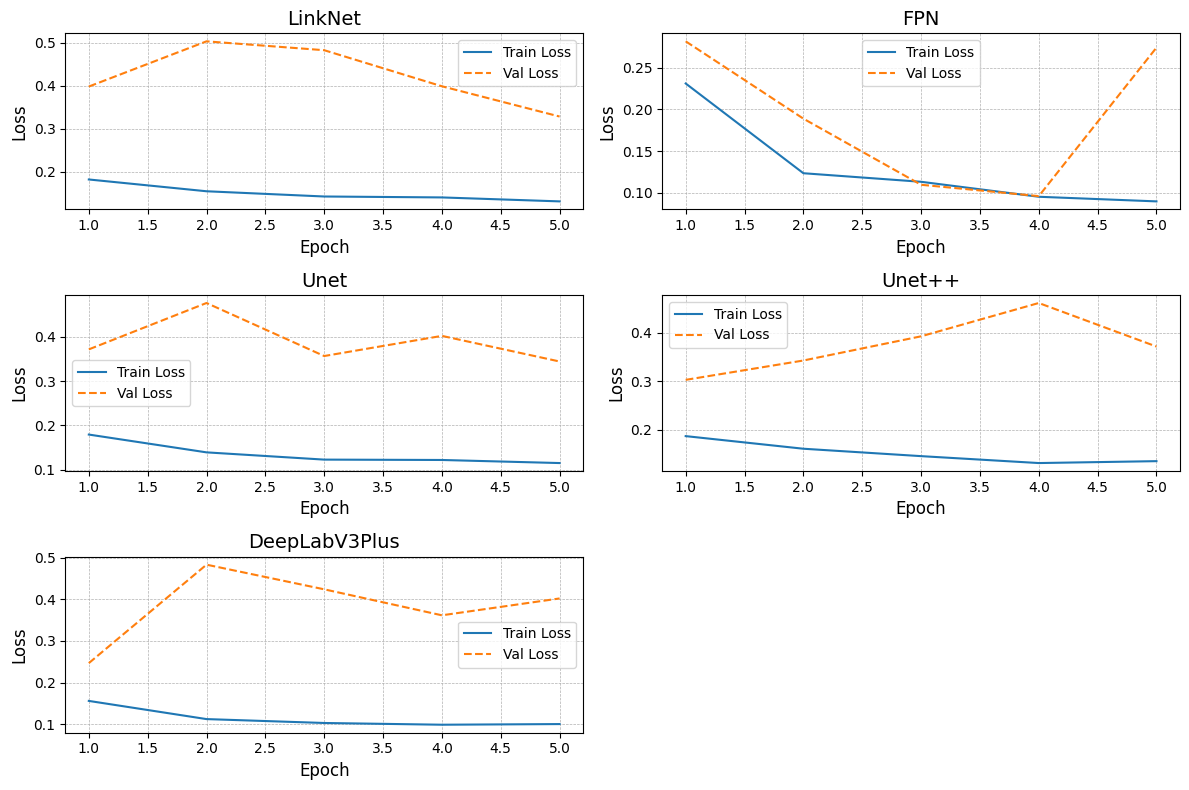

In [ ]:
# Determine the grid size for the subplots.
n_models = len(loss_history)
n_cols = 2  # Set the desired number of columns
n_rows = math.ceil(n_models / n_cols)

epochs = range(1, NUM_EPOCHS + 1)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 8))
# If there is only one row, axs might be 1D, so we flatten for consistency:
axs = axs.flatten() if n_models > 1 else [axs]

for i, (key, history) in enumerate(loss_history.items()):
    axs[i].plot(epochs, history["train"], label=f"Train Loss")
    axs[i].plot(epochs, history["val"], label=f"Val Loss", linestyle="--")
    axs[i].set_title(key, fontsize=14)
    axs[i].set_xlabel("Epoch", fontsize=12)
    axs[i].set_ylabel("Loss", fontsize=12)
    axs[i].grid(True, which="both", linestyle="--", linewidth=0.5)
    axs[i].legend(fontsize=10)

# Hide any unused subplots if n_models < n_rows*n_cols
for j in range(i+1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()


Model: LinkNet


<ipython-input-122-6af42ecbf6e5>:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(os.path.join(path_task1, "models", key, "best_model.pth"), map_loc

Test Loss: 0.4797
Metrics:
  Mean IOU: 0.2673
  Mean Precision: 0.3694
  Mean Recall: 0.6906
  Class 0: IOU: 0.7004, Precision: 1.0000, Recall: 0.7004
  Class 1: IOU: 0.0628, Precision: 0.0693, Recall: 0.4001
  Class 2: IOU: 0.0387, Precision: 0.0388, Recall: 0.9715
Model: FPN
Test Loss: 0.1911
Metrics:
  Mean IOU: 0.4082
  Mean Precision: 0.4310
  Mean Recall: 0.7476
  Class 0: IOU: 0.9408, Precision: 0.9989, Recall: 0.9418
  Class 1: IOU: 0.0565, Precision: 0.0622, Recall: 0.3806
  Class 2: IOU: 0.2274, Precision: 0.2319, Recall: 0.9204
Model: Unet
Test Loss: 0.4902
Metrics:
  Mean IOU: 0.2806
  Mean Precision: 0.3795
  Mean Recall: 0.6646
  Class 0: IOU: 0.7182, Precision: 0.9981, Recall: 0.7192
  Class 1: IOU: 0.0851, Precision: 0.1019, Recall: 0.3403
  Class 2: IOU: 0.0384, Precision: 0.0385, Recall: 0.9344
Model: Unet++
Test Loss: 0.4536
Metrics:
  Mean IOU: 0.2693
  Mean Precision: 0.3731
  Mean Recall: 0.6664
  Class 0: IOU: 0.7006, Precision: 1.0000, Recall: 0.7006
  Class 1: 

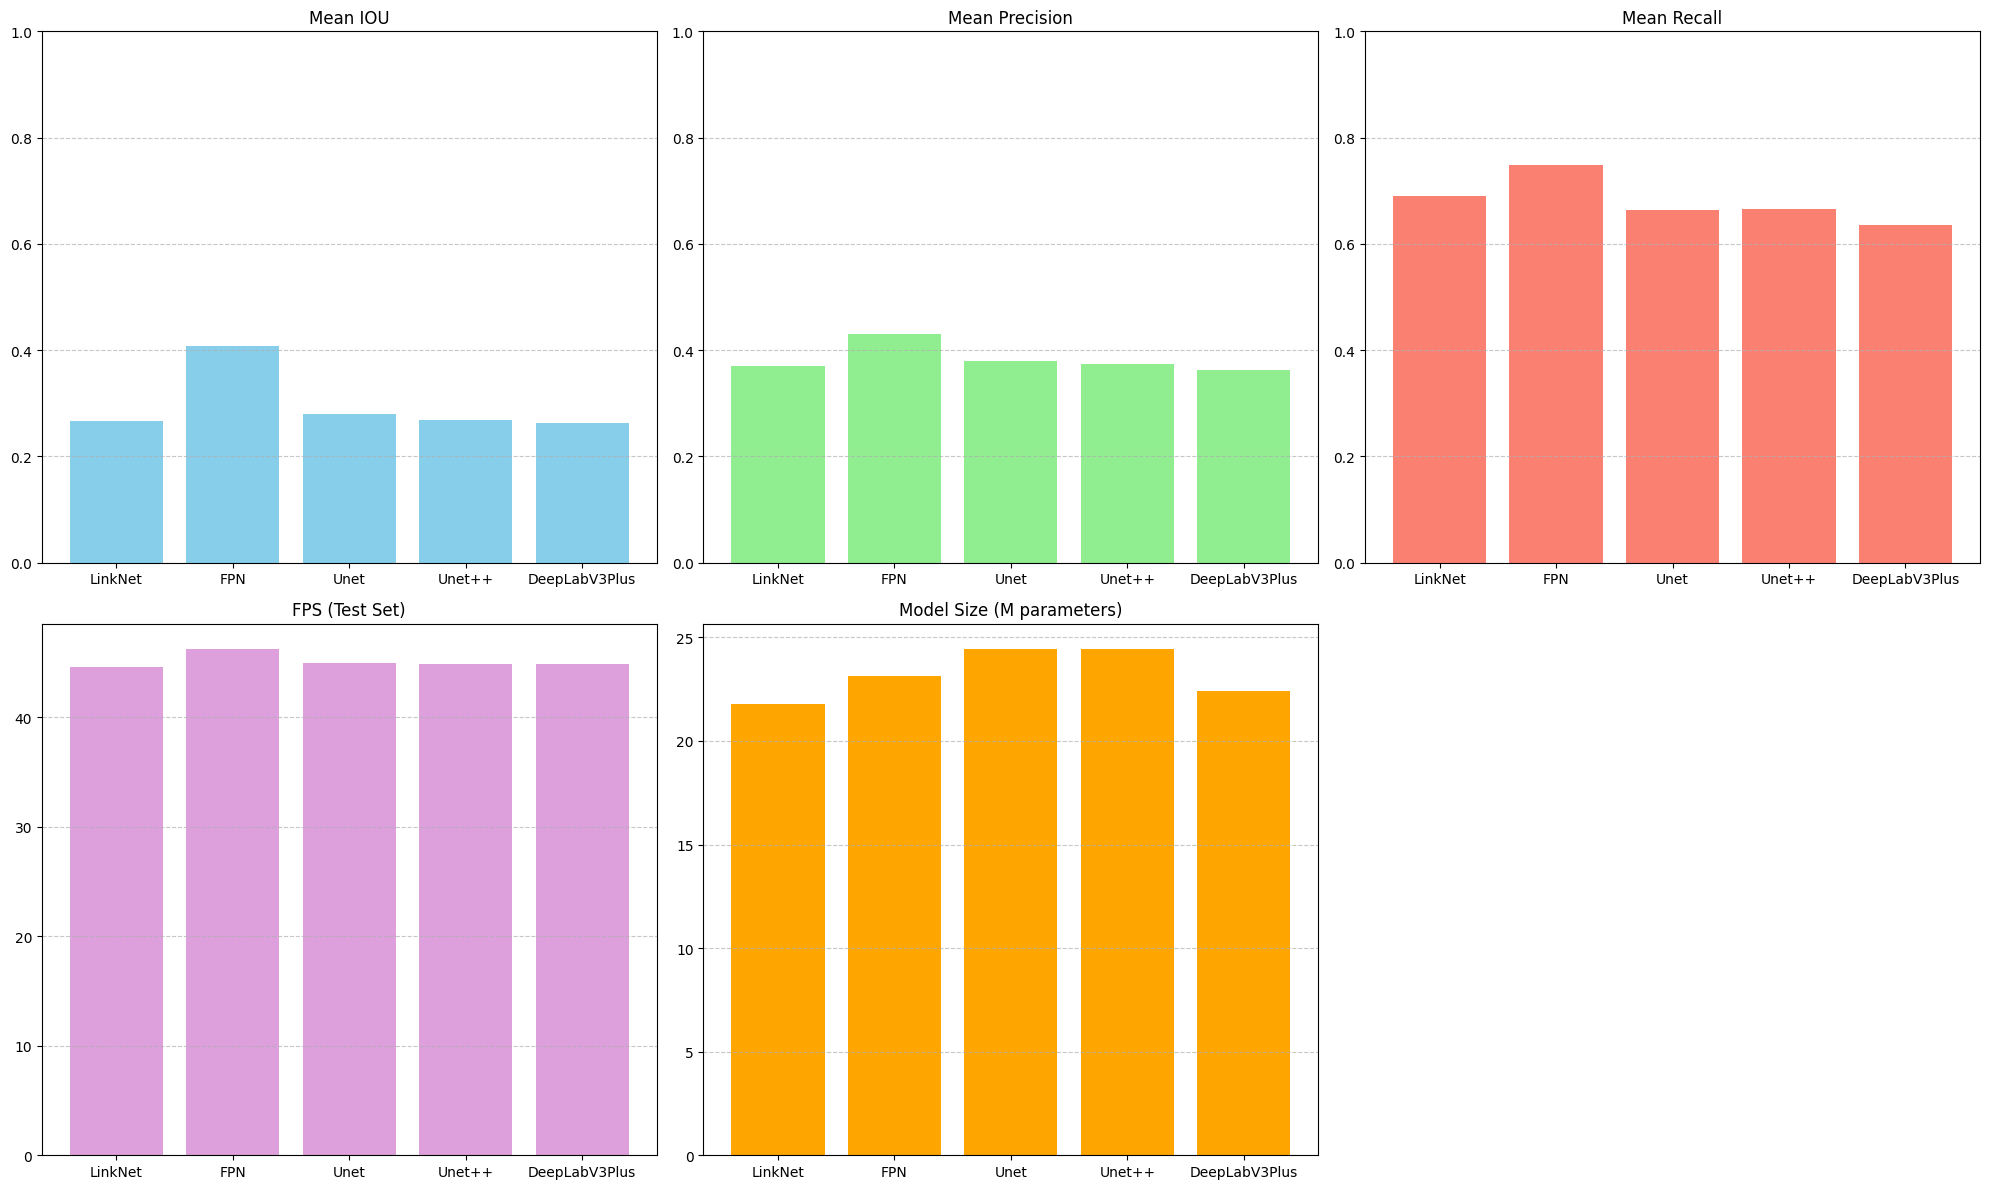

In [ ]:
def test_model(model, test_loader, criterion, device, num_classes=3):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_targets = []

    with torch.no_grad():
      for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)
        total_loss += loss.item()

        # Save predictions and targets for metric calculations
        all_preds.append(outputs.cpu())
        all_targets.append(masks.cpu())

    avg_loss = total_loss / len(test_loader)

    # Concatenate all predictions and targets
    all_preds = torch.cat(all_preds, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    # Evaluate using your multi-class evaluation function.
    metrics = eval_multi_class(all_preds, all_targets, num_classes=num_classes)

    print(f"Test Loss: {avg_loss:.4f}")
    print("Metrics:")
    print(f"  Mean IOU: {metrics['IOU']:.4f}")
    print(f"  Mean Precision: {metrics['Precision']:.4f}")
    print(f"  Mean Recall: {metrics['Recall']:.4f}")
    for i, (iou, prec, rec) in enumerate(zip(metrics["Class-wise IOU"], metrics["Class-wise Precision"], metrics["Class-wise Recall"])):
        print(f"  Class {i}: IOU: {iou:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}")

    return metrics


# Helper function to calculate model size in number of parameters
def get_model_size(model):
    return sum(p.numel() for p in model.parameters())

# Evaluate models on test data and measure inference time
all_metrics = {}
all_model_sizes = {}
for key, cfg in models.items():
    model = cfg["model"]
    # Load best model weights and move to device
    state_dict = torch.load(os.path.join(path_task1, "models", key, "best_model.pth"), map_location=device)
    model.load_state_dict(state_dict)
    model.to(device)

    # Measure inference time
    start_time = time.time()
    print(f"Model: {key}")
    metrics = test_model(model, test_loader, criterion, device, num_classes=3)
    end_time = time.time()

    elapsed = end_time - start_time
    num_samples = len(test_loader.dataset)
    fps = num_samples / elapsed if elapsed > 0 else 0

    # Store metrics plus FPS
    metrics["FPS"] = fps
    all_metrics[key] = metrics

    # Compute and store model size (in millions)
    size = get_model_size(model) / 1e6  # convert to millions
    all_model_sizes[key] = size

print("Metrics collected:")
for m_name, m_vals in all_metrics.items():
    print(m_name, m_vals)
print("Model sizes (M parameters):", all_model_sizes)

# Prepare data for plotting
model_names = list(all_metrics.keys())
ious = [all_metrics[m]["IOU"] for m in model_names]
precisions = [all_metrics[m]["Precision"] for m in model_names]
recalls = [all_metrics[m]["Recall"] for m in model_names]
fpss = [all_metrics[m]["FPS"] for m in model_names]
model_sizes = [all_model_sizes[m] for m in model_names]

x = np.arange(len(model_names))  # x-axis positions for the bars

# Create a figure with multiple subplots arranged in 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

# Plot Mean IOU
axes[0].bar(x, ious, color="skyblue")
axes[0].set_xticks(x)
axes[0].set_xticklabels(model_names)
axes[0].set_title("Mean IOU")
axes[0].set_ylim([0, 1])
axes[0].grid(True, axis="y", linestyle="--", alpha=0.7)

# Plot Mean Precision
axes[1].bar(x, precisions, color="lightgreen")
axes[1].set_xticks(x)
axes[1].set_xticklabels(model_names)
axes[1].set_title("Mean Precision")
axes[1].set_ylim([0, 1])
axes[1].grid(True, axis="y", linestyle="--", alpha=0.7)

# Plot Mean Recall
axes[2].bar(x, recalls, color="salmon")
axes[2].set_xticks(x)
axes[2].set_xticklabels(model_names)
axes[2].set_title("Mean Recall")
axes[2].set_ylim([0, 1])
axes[2].grid(True, axis="y", linestyle="--", alpha=0.7)

# Plot FPS (inference speed)
axes[3].bar(x, fpss, color="plum")
axes[3].set_xticks(x)
axes[3].set_xticklabels(model_names)
axes[3].set_title("FPS (Test Set)")
axes[3].grid(True, axis="y", linestyle="--", alpha=0.7)

# Plot Model Size (in millions of parameters)
axes[4].bar(x, model_sizes, color="orange")
axes[4].set_xticks(x)
axes[4].set_xticklabels(model_names)
axes[4].set_title("Model Size (M parameters)")
axes[4].grid(True, axis="y", linestyle="--", alpha=0.7)

# If you have a 6th subplot available, you can leave it empty or add another metric.
axes[5].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Based on the result FPN seems to have the best performance

CHOSEN_MODEL = "FPN"
cfg = models[CHOSEN_MODEL]
model = cfg["model"]
state_dict = torch.load(os.path.join(path_task1,
                                     "models",
                                     CHOSEN_MODEL,
                                     "best_model.pth"),
                                     map_location=device)
model.load_state_dict(state_dict)
model.to(device)

<ipython-input-137-69c5dffa231f>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(os.path.join(path_task1,


FPN(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

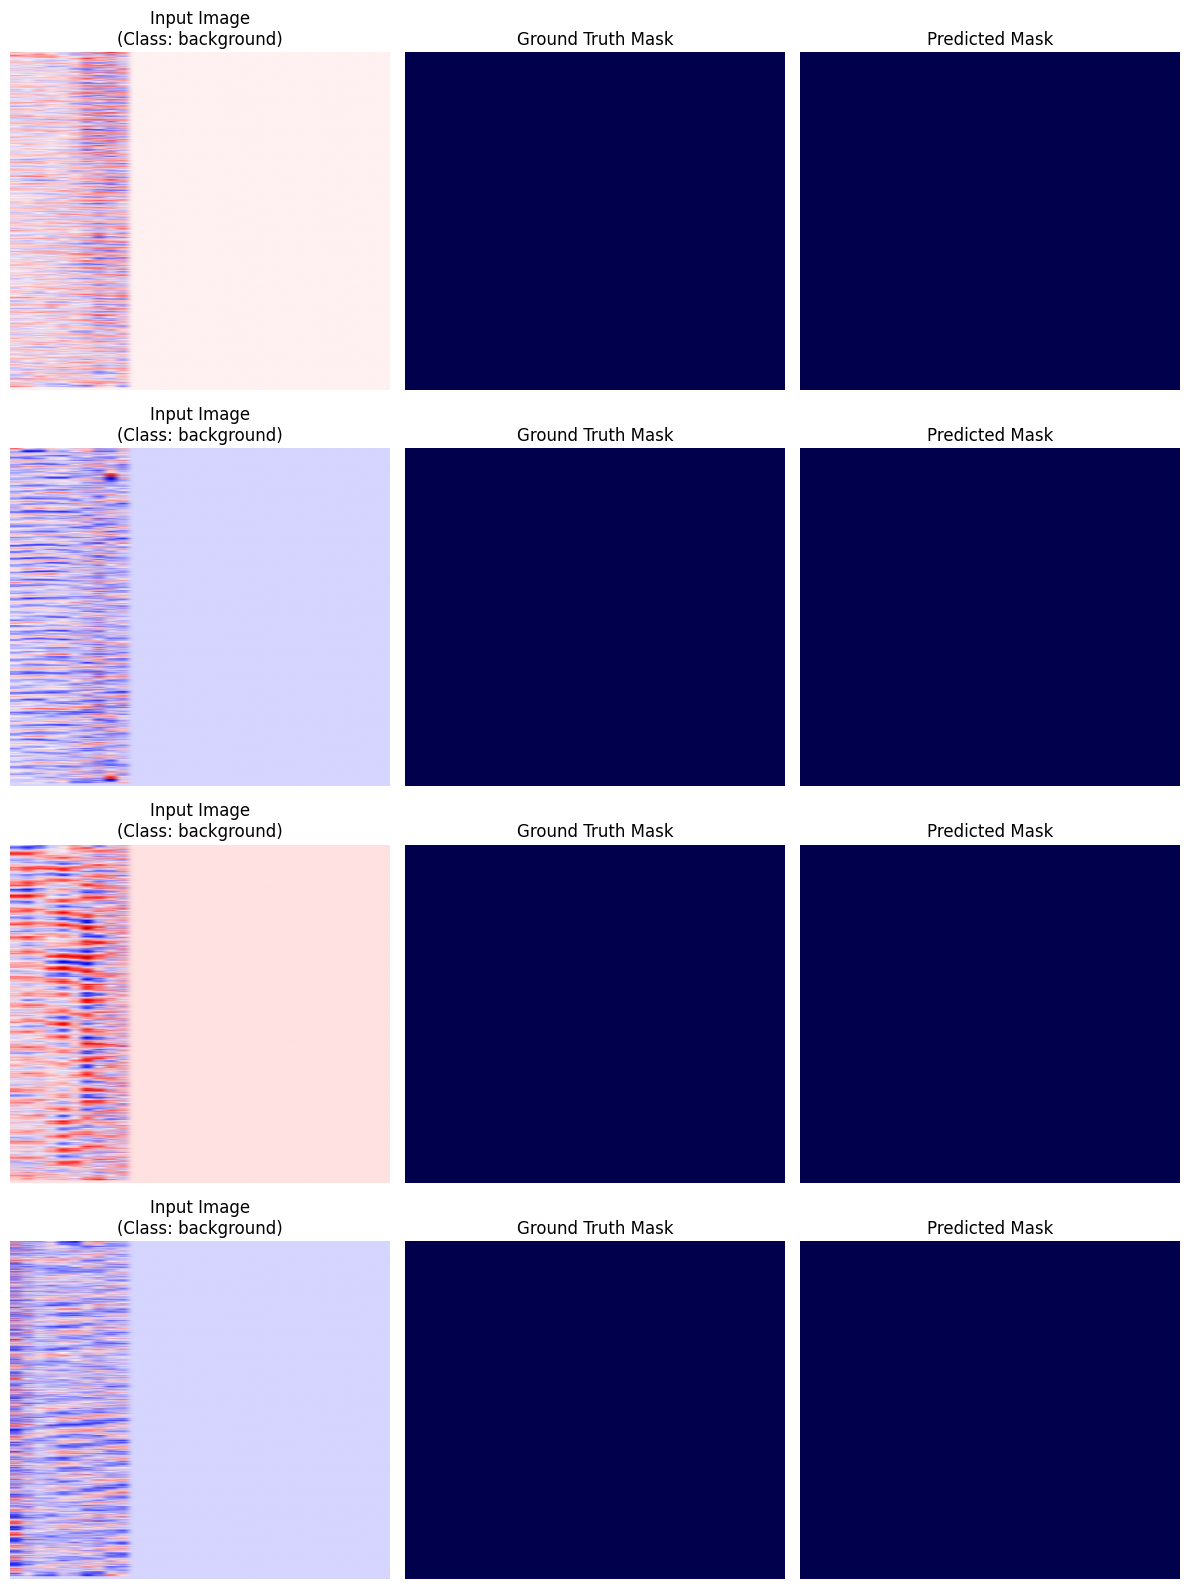

In [ ]:
def get_majority_class(mask):
    """
    Return the label (as a string) corresponding to the majority class in mask.
    Assumes mask has discrete integer values.
    """
    # Flatten the mask and count occurrences.
    counts = np.bincount(mask.flatten())
    # Majority label is the index with the maximum count.
    majority = np.argmax(counts)
    # Find the corresponding key in CLASS_ID
    key = next((k for k, v in CLASS_ID.items() if v == majority), str(majority))
    return key

def plot_random_model_outputs(model, dataset, device, num_images=4):
    """
    Randomly samples `num_images` from the dataset and plots:
      - The input image
      - The ground truth mask (with a label indicating the majority class)
      - The model prediction
    All plots are arranged in rows (one row per sample) with 3 columns.
    """
    model.eval()
    indices = random.sample(range(len(dataset)), num_images)

    images_list = []
    masks_list = []
    for idx in indices:
        image, mask = dataset[idx]
        images_list.append(image)
        masks_list.append(mask)

    # Stack images and masks to form a batch
    images_batch = torch.stack(images_list).to(device)  # shape: [B, C, H, W]
    # Note: masks remain on CPU
    # Get predictions
    with torch.no_grad():
        outputs = model(images_batch)  # Expected shape: [B, classes, H, W]
        preds = torch.argmax(outputs, dim=1)  # shape: [B, H, W]

    images_np = images_batch.cpu().numpy()  # [B, C, H, W]
    masks_np = torch.stack(masks_list).numpy()  # [B, H, W]
    preds_np = preds.cpu().numpy()  # [B, H, W]

    # Set up the plot grid: one row per image, three columns.
    fig, axs = plt.subplots(num_images, 3, figsize=(12, 4*num_images))

    # If only one image, make axs iterable
    if num_images == 1:
        axs = [axs]

    cmap = "seismic"

    for i in range(num_images):
        # For the input image, if grayscale, display first channel.
        input_img = images_np[i, 0, :, :]
        majority_label = get_majority_class(masks_np[i])

        axs[i][0].imshow(input_img, cmap=cmap, aspect="auto")
        axs[i][0].set_title(f"Input Image\n(Class: {majority_label})", fontsize=12)
        axs[i][0].axis("off")

        # Ground truth mask
        axs[i][1].imshow(masks_np[i], cmap=cmap, interpolation="nearest", aspect="auto")
        axs[i][1].set_title("Ground Truth Mask", fontsize=12)
        axs[i][1].axis("off")

        # Predicted mask
        axs[i][2].imshow(preds_np[i], cmap=cmap, interpolation="nearest", aspect="auto")
        axs[i][2].set_title("Predicted Mask", fontsize=12)
        axs[i][2].axis("off")

    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming 'test_dataset' is your dataset instance, and 'model' is your loaded model.
plot_random_model_outputs(model, test_dataset, device, num_images=4)



#Task 2: Inference

Reading the images at once will not fit the GPU. Thefore we will slice the image and allow a certain overlap when we slide the window


In [ ]:

def sliding_window_inference_tensor(image_tensor, model, patch_size=(1024, 896), overlap=0.2, device='cuda'):
    """
    Performs sliding window inference on a large input image tensor.

    Parameters:
      image_tensor: torch.Tensor of shape [C, H, W] (e.g., grayscale: [1, H, W] or RGB: [3, H, W])
      model: segmentation model (in eval mode) that expects input shape [B, C, H, W]
      patch_size: tuple (patch_height, patch_width) for each patch.
      overlap: fraction of overlap between patches (e.g., 0.2 means 20% overlap)
      device: device to perform inference on.

    Returns:
      final_prediction: torch.Tensor of shape [H, W] (with predicted class indices)
    """
    # Ensure the input tensor is on CPU (we'll move patches to device as needed)
    image_tensor = image_tensor.cpu()

    C, H, W = image_tensor.shape
    patch_h, patch_w = patch_size

    # Compute strides based on overlap
    stride_h = int(patch_h * (1 - overlap))
    stride_w = int(patch_w * (1 - overlap))

    # Create tensors to accumulate predictions and counts for overlapping regions.
    # We work on device to avoid extra CPU-GPU transfers.
    full_prediction = torch.zeros((H, W), dtype=torch.float32, device=device)
    count_map = torch.zeros((H, W), dtype=torch.float32, device=device)

    # Iterate over the image with the sliding window.
    # (This simple version may not cover the very right or bottom edges if H or W is not exactly divisible.)
    for top in range(0, H - patch_h + 1, stride_h):
        for left in range(0, W - patch_w + 1, stride_w):
            # Extract patch of shape [C, patch_h, patch_w]
            patch = image_tensor[:, top:top+patch_h, left:left+patch_w]
            # Add batch dimension: shape becomes [1, C, patch_h, patch_w]
            patch = patch.unsqueeze(0).to(device)

            # Run inference on the patch
            with torch.no_grad():
                output = model(patch)  # Expected output shape: [1, num_classes, patch_h, patch_w]
                # Get predicted class indices: shape [1, patch_h, patch_w]
                pred_patch = torch.argmax(output, dim=1)

            # Remove batch dimension; now shape [patch_h, patch_w]
            pred_patch = pred_patch[0].float()

            # Accumulate the predictions and increment count_map in the overlapping region
            full_prediction[top:top+patch_h, left:left+patch_w] += pred_patch
            count_map[top:top+patch_h, left:left+patch_w] += 1.0

    # Avoid division by zero: if any pixel wasn't covered, set its count to 1 (or you could handle separately)
    count_map[count_map == 0] = 1.0
    averaged_prediction = full_prediction / count_map
    # Since predictions are discrete class indices, we round to get the final prediction.
    final_prediction = torch.round(averaged_prediction).to(torch.long)

    return final_prediction



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

# Convert a grayscale image to 3-channel by repeating along the channel dimension:
input_tensor = torch.from_numpy(inference_image)  # shape: [H, W]
input_tensor = input_tensor.unsqueeze(0).repeat(1, 1, 1)  # shape: [1, H, W]
input_tensor = input_tensor.float()
#input_tensor = input_tensor.unsqueeze(0).float().to(device)  # shape: [1, 1, H, W]

print("Input tensor shape:", input_tensor.shape)



# Set desired patch size and overlap for inference.
patch_size = (1024, 896)  # Adjust based on available memory and desired patch size.
overlap = 0.2  # 20% overlap
predicted_mask = sliding_window_inference_tensor(input_tensor, model, patch_size, overlap, device)
predicted_mask = predicted_mask.cpu().numpy()



Input tensor shape: torch.Size([1, 120000, 896])


<ipython-input-136-39565624fc23>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap(cmap)


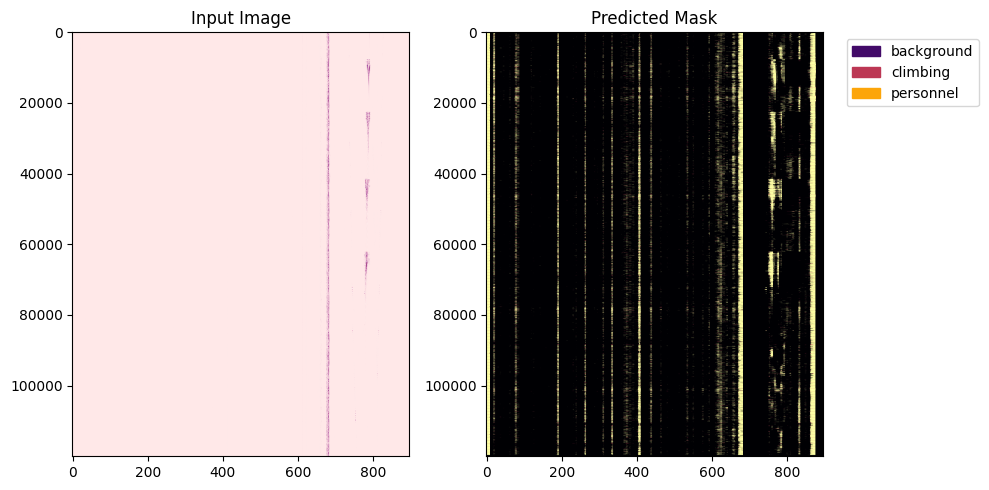

In [ ]:
# Define your colormap and class mapping

class_labels = {0: "Background", 1: "Climbing", 2: "Personnel"}

# Get the colormap object
colormap = plt.cm.get_cmap(cmap)

# Choose representative colors for each class.
# Adjust the values (0-1) as needed to get distinct colors.
colors = {
    0: colormap(0.2),  # Background
    1: colormap(0.5),  # Climbing
    2: colormap(0.8)   # Personnel
}

# Create legend handles for each class.
patches = [mpatches.Patch(color=colors[CLASS_ID[key]], label=key) for key in CLASS_ID]


# Plot the images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(inference_image, cmap="seismic", aspect="auto")
plt.title("Input Image")
#plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(predicted_mask, cmap="inferno", aspect="auto")
plt.title("Predicted Mask")
#plt.axis("off")

# Add the legend outside the plot (for the predicted mask)
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [145]:


def run_inference_on_large_image(model, image_tensor, device,
                                 patch_size=(1024, 896), overlap=0.2, num_iterations=10):
    """
    Runs inference on a large image tensor using sliding window inference,
    displays the output, and computes FPS.

    Parameters:
      - model: The segmentation model in eval mode.
      - image_tensor: A torch.Tensor of shape [C, H, W] (e.g., [1, H, W] for grayscale).
      - device: The torch.device to run inference on.
      - patch_size: Size of each patch (height, width).
      - overlap: Fraction of overlap between patches.
      - num_iterations: Number of iterations to run for averaging FPS.
    """
    model.eval()
    fps_list = []

    # Ensure the image tensor is on CPU initially, as the sliding window function does that.
    if image_tensor.device != torch.device("cpu"):
        image_tensor = image_tensor.cpu()

    for i in range(num_iterations):
        start_time = time.time()
        # Run sliding window inference on the large image tensor.
        pred_tensor = sliding_window_inference_tensor(image_tensor, model, patch_size, overlap, device)
        elapsed = time.time() - start_time
        fps = 1.0 / elapsed if elapsed > 0 else 0
        fps_list.append(fps)

        # Convert prediction to numpy for visualization.
        pred_np = pred_tensor.cpu().numpy()

        # Display the input image and predicted mask side-by-side.
        plt.figure(figsize=(12, 6))

        # Plot input image.
        plt.subplot(1, 2, 1)
        # If grayscale ([1, H, W]), squeeze channel dimension.
        if image_tensor.shape[0] == 1:
            img_disp = image_tensor.squeeze(0).numpy()
            plt.imshow(img_disp, cmap="seismic", aspect="auto")
        else:
            # For multi-channel, assume [C, H, W] and transpose to [H, W, C].
            img_disp = image_tensor.permute(1, 2, 0).numpy()
            plt.imshow(img_disp, aspect="auto")
        plt.title("Input Image")
        plt.axis("off")

        # Plot predicted segmentation mask.
        plt.subplot(1, 2, 2)
        plt.imshow(pred_np, cmap="jet", aspect="auto")
        plt.title(f"Prediction (FPS: {fps:.2f})")
        plt.axis("off")

        plt.tight_layout()
        plt.show()
        clear_output(wait=True)

    avg_fps = sum(fps_list) / len(fps_list)
    print(f"Average FPS over {num_iterations} iterations: {avg_fps:.2f}")

# Example usage:
# Suppose you have a large inference image loaded as a NumPy array and converted to a tensor.
# For a grayscale image:
# inference_image = np.load("path/to/large_inference_image.npy")  # shape [H, W]
# inference_tensor = torch.from_numpy(inference_image).unsqueeze(0).float()  # shape [1, H, W]
#
# Ensure your model is loaded and moved to device:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)
#
# Then run:
run_inference_on_large_image(model, input_tensor, device, patch_size=(1024, 896), overlap=0.2, num_iterations=10)


Average FPS over 10 iterations: 0.80


#Task 4: Testing new sample